# Exploratory Analysis on Popular Genres, High Return on Production Budget Genres, and Hot Years Based on Votes

### Standard imports

In [2]:
# 3rd party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# standard library
import sqlite3

### Globally used variables and functions

In [277]:
# translate genre ids to genre from https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee
comment = """Action          28
Adventure       12
Animation       16
Comedy          35
Crime           80
Documentary     99
Drama           18
Family          10751
Fantasy         14
History         36
Horror          27
Music           10402
Mystery         9648
Romance         10749
Science Fiction 878
TV Movie        10770
Thriller        53
War             10752
Western         37"""
id_to_genre = {line.split(' ')[-1]:line.split(' ')[0].lower() for line in comment.split('\n')}

In [278]:
def convert_ids(line):
    return ','.join(sorted([id_to_genre.get(x.strip(), x.strip()) for x in line[1:-1].split(',')]))

In [390]:
# https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
# https://seaborn.pydata.org/generated/seaborn.color_palette.html
custom_palette = 'blend:#046A38,#86BC25'

def colors_from_values(values, palette_name=custom_palette):
    # normalize the values to range [0, 1]
    normalized = (values - np.min(values)) / (np.max(values) - np.min(values))
    # convert to indices
    indices = np.round((1 - normalized) * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [157]:
sns.set_theme(style="whitegrid")

## Are certain genres more popular?

In [250]:
df = pd.read_csv('../data/tmdb.movies.csv')

In [251]:
df['augmented_genre'] = df.genre_ids.apply(convert_ids)

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
 10  augmented_genre    26517 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 2.2+ MB


In [253]:
# drop columns that aren't useful to popularity analysis
df.drop(columns=["Unnamed: 0", 'id'], inplace=True)

In [254]:
# filter for movies that have been reviewed by a decent amount of people
votes_over_100 = df[df['vote_count'] > 100]

In [256]:
grouped_genre = votes_over_100.groupby('augmented_genre')

In [260]:
# get genres with at least more than 5 examples of that genre
genres_over_five_movies = grouped_genre.filter(lambda x: len(x) > 5)

<Axes: xlabel='augmented_genre'>

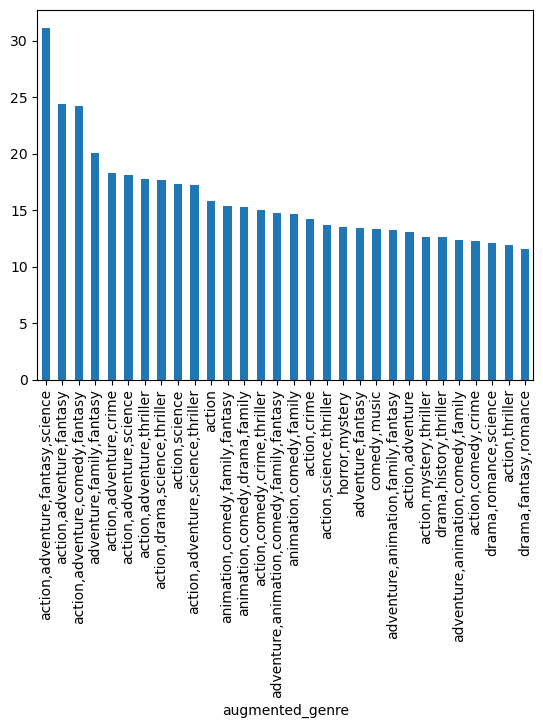

In [262]:
genres_over_five_movies.groupby('augmented_genre').median(numeric_only=True).sort_values('popularity', ascending=False).popularity.iloc[:30].plot.bar()

## Are certain years more hot in terms of popularity?

In [164]:
genres_over_five_movies['year'] = genres_over_five_movies.release_date.str.slice(stop=4)

In [173]:
over_50_movies = genres_over_five_movies.groupby('year').filter(lambda x: len(x) > 50)


In [185]:
over_50_movies.groupby('year').mean()

C:\Users\hzuo\AppData\Local\Temp\ipykernel_12364\3208799122.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  over_50_movies.groupby('year').mean()


,popularity,vote_average,vote_count
year,,,
2010,10.593665,6.420305,1485.284264
2011,10.144743,6.357721,1168.459559
2012,10.173396,6.274615,1319.623077
2013,9.938601,6.308589,1365.656442
2014,10.234542,6.338482,1103.243902
2015,10.838840,6.250000,1367.180000
2016,10.743977,6.377143,1478.872727
2017,11.970218,6.409302,1340.741279
2018,15.958690,6.508487,966.959410


C:\Users\hzuo\AppData\Local\Temp\ipykernel_12364\4130641119.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  over_50_movies.groupby('year').median().plot.line(y='vote_count')


<Axes: xlabel='year'>

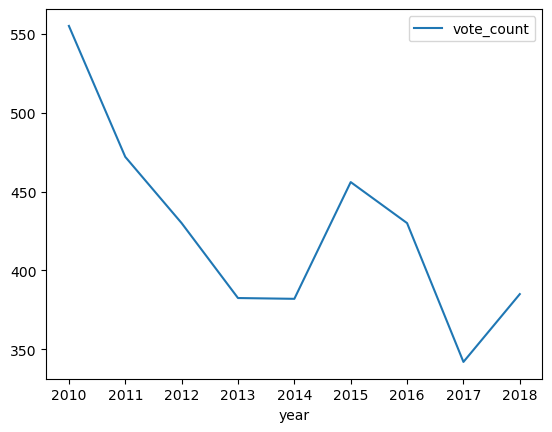

In [193]:
over_50_movies.groupby('year').median().plot.line(y='vote_count')

C:\Users\hzuo\AppData\Local\Temp\ipykernel_12364\2334026813.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  over_50_movies.groupby('year').median().plot.line(y='vote_average')


<Axes: xlabel='year'>

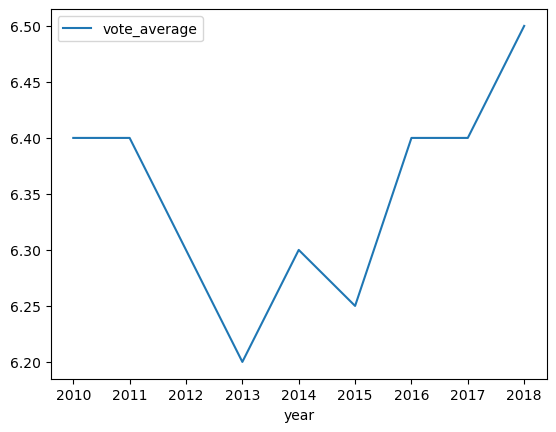

In [187]:
over_50_movies.groupby('year').median().plot.line(y='vote_average')

C:\Users\hzuo\AppData\Local\Temp\ipykernel_12364\228705581.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  over_50_movies.groupby('year').median().plot.line(y='popularity')


<Axes: xlabel='year'>

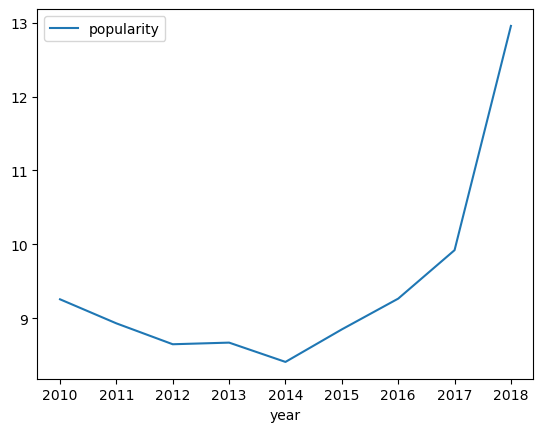

In [188]:
over_50_movies.groupby('year').median().plot.line(y='popularity')

## Highest return on budget?

### Load budget data

In [61]:
budget_df = pd.read_csv('../data/tn.movie_budgets.csv', thousands=',')

In [62]:
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [63]:
budget_df.drop(columns=['id'], inplace=True)

In [64]:
budget_df.head(2)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [65]:
budget_df['worldwide_gross'] = budget_df['worldwide_gross'].str.lstrip('$').str.replace(',', '').astype(np.int64)

In [66]:
budget_df['production_budget'] = budget_df['production_budget'].str.lstrip('$').str.replace(',', '').astype(np.int64)

In [67]:
budget_df.head(2)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,425000000,"$760,507,625",2776345279
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875",1045663875


In [68]:
non_zero = budget_df[(budget_df['worldwide_gross'] > 0) & (budget_df['production_budget'] > 0)].copy()

In [69]:
non_zero.describe()

,production_budget,worldwide_gross
count,5.415000e+03,5.415000e+03
mean,3.330801e+07,9.768800e+07
std,4.248758e+07,1.788591e+08
min,1.100000e+03,2.600000e+01
25%,6.000000e+06,7.004834e+06
50%,1.900000e+07,3.333987e+07
75%,4.200000e+07,1.044590e+08
max,4.250000e+08,2.776345e+09


In [70]:
budget_df['return_on_budget'] = (budget_df['worldwide_gross'] / budget_df['production_budget'])

In [71]:
budget_df.sort_values(by=['return_on_budget'], ascending=False, inplace=True)

In [72]:
budget_df.head(2)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,return_on_budget
5745,"Jun 30, 1972",Deep Throat,25000,"$45,000,000",45000000,1800.00
5613,"Mar 21, 1980",Mad Max,200000,"$8,750,000",99750000,498.75


**To target the most moviegoers with the least movies, we should look at movies made within the last [30 years](https://www.mekkographics.com/american-moviegoers-by-age-and-ethnicity/#:~:text=Younger%20Americans%20are%20more%20frequent,and%20over%20only%20attended%202.3.).**

In [73]:
# change the release date format before masking
budget_df['release_date'] = pd.to_datetime(budget_df['release_date'], infer_datetime_format=True)

In [85]:
last_30_years = budget_df[budget_df['release_date'].dt.year > 1990].copy()

In [86]:
last_30_years.head(2)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,return_on_budget
5492,2009-09-25,Paranormal Activity,450000,"$107,918,810",194183034,431.517853
5679,2015-07-10,The Gallows,100000,"$22,764,410",41656474,416.564740


In [87]:
# lowercase the movie titles for a more complete merge
last_30_years['movie'] = last_30_years['movie'].str.lower()

### Load genre data

In [88]:
genres_df = pd.read_csv('../data/tmdb.movies.csv')

In [89]:
genres_df.columns

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [90]:
# convert genre ids to human understandable genres
genres_df['genre'] = genres_df['genre_ids'].apply(convert_ids)

In [91]:
# drop extraneous columns
genres_df.drop(columns=["Unnamed: 0", 'id'], inplace=True)

In [92]:
# convert date format to match budget data's format
genres_df['release_date'] = pd.to_datetime(genres_df['release_date'])

In [93]:
# lowercase for better merge with budget data
genres_df['title'] = genres_df['title'].str.lower()

In [94]:
budget_genre = last_30_years.merge(genres_df, left_on=['movie', 'release_date'], right_on=['title', 'release_date'], how='inner').drop_duplicates()

In [95]:
budget_genre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 0 to 1422
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       1294 non-null   datetime64[ns]
 1   movie              1294 non-null   object        
 2   production_budget  1294 non-null   int64         
 3   domestic_gross     1294 non-null   object        
 4   worldwide_gross    1294 non-null   int64         
 5   return_on_budget   1294 non-null   float64       
 6   genre_ids          1294 non-null   object        
 7   original_language  1294 non-null   object        
 8   original_title     1294 non-null   object        
 9   popularity         1294 non-null   float64       
 10  title              1294 non-null   object        
 11  vote_average       1294 non-null   float64       
 12  vote_count         1294 non-null   int64         
 13  genre              1294 non-null   object        
dtypes: datet

### Genre analysis on top 50 movies with high return on production budget

In [96]:
# get top 50 return on production movies and their genres after splitting into individual genres
genre_split = budget_genre.iloc[:50].genre.str.split(',').explode('genre').value_counts()
genre_split_df = genre_split.reset_index()
genre_split_df.columns = ['genre', 'count']

In [97]:
# get top 50 return on production movies and their combined genres
genre_combined = budget_genre.iloc[:50].genre.value_counts()
genre_combined_df = genre_combined.reset_index()
genre_combined_df.columns = ['genre', 'count']

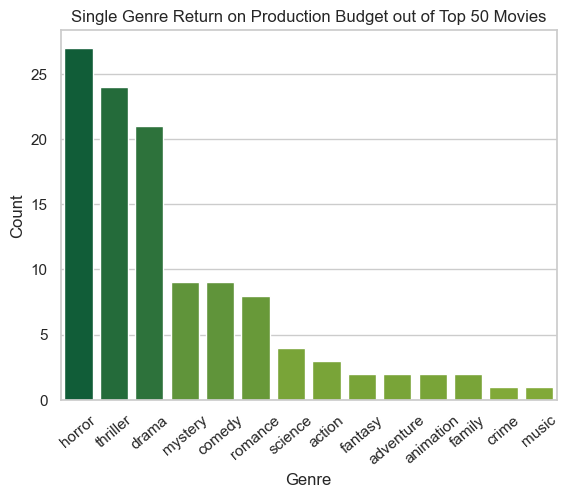

In [391]:
sns.barplot(data=genre_split_df, x='genre', y='count', palette=colors_from_values(genre_split_df['count']))
plt.title('Single Genre Return on Production Budget out of Top 50 Movies')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=40)
None

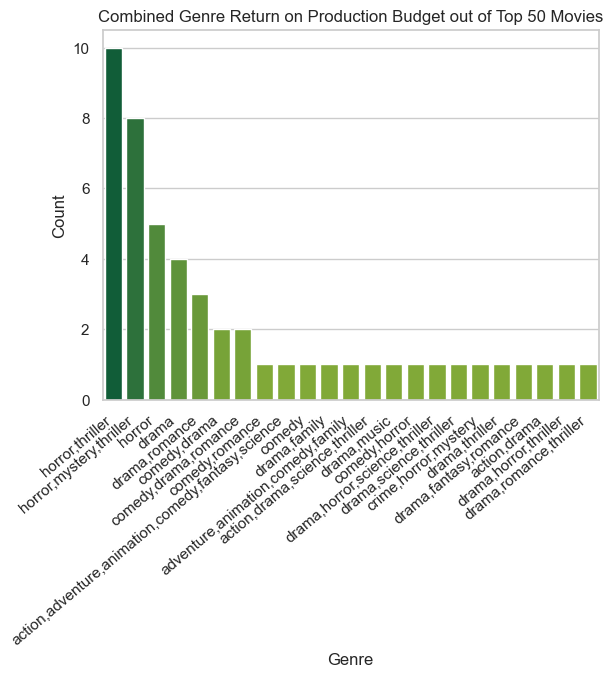

In [275]:
sns.barplot(data=genre_combined_df, x='genre', y='count', palette=colors_from_values(genre_combined_df['count']))
plt.title('Combined Genre Return on Production Budget out of Top 50 Movies')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=40, horizontalalignment='right')
None

### Median genre return on production budget

In [106]:
grouped_by_genre = budget_genre.groupby('genre')

In [145]:
at_least_20_in_genre = grouped_by_genre.filter(lambda x: len(x) >= 20)

In [146]:
median_genre = at_least_20_in_genre.groupby('genre')['return_on_budget'].median().sort_values(ascending=False)
median_genre_df = median_genre.reset_index()
median_genre_df.columns = ['genre', 'median return on budget']

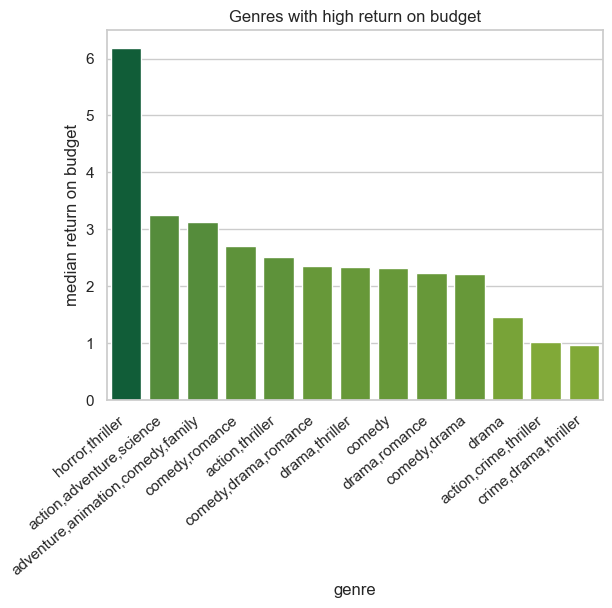

In [276]:
sns.barplot(data=median_genre_df, x='genre', y='median return on budget', palette=colors_from_values(median_genre_df['median return on budget']))
plt.title('Genres with high return on budget')
plt.xticks(rotation=40, horizontalalignment='right')
None

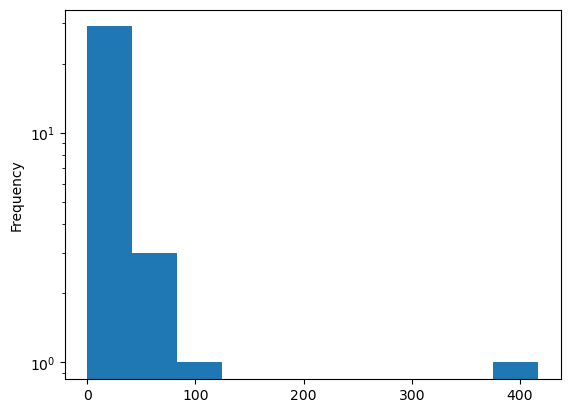

In [148]:
budget_genre[budget_genre.genre == 'horror,thriller'].return_on_budget.plot.hist()
plt.yscale('log')

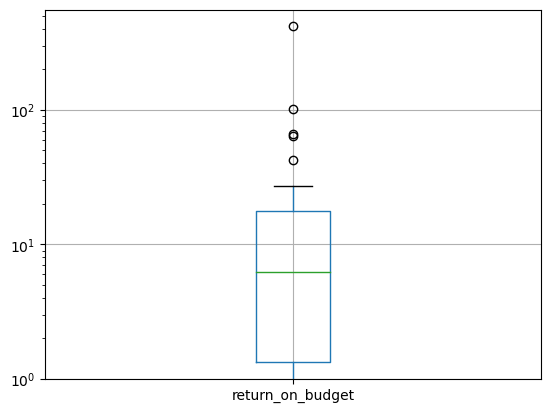

In [152]:
budget_genre[budget_genre.genre == 'horror,thriller'].boxplot('return_on_budget')
plt.yscale('log')

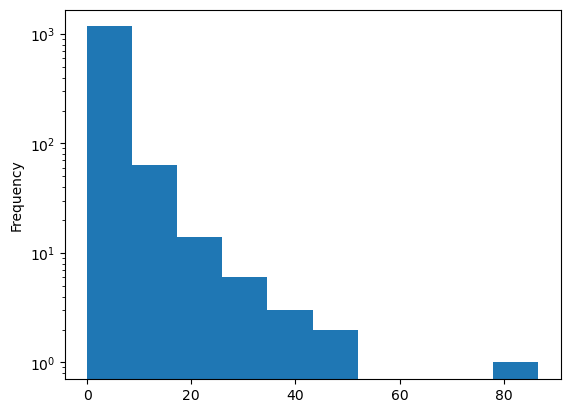

In [138]:
budget_genre[budget_genre.genre != 'horror,thriller'].return_on_budget.plot.hist()
plt.yscale('log')

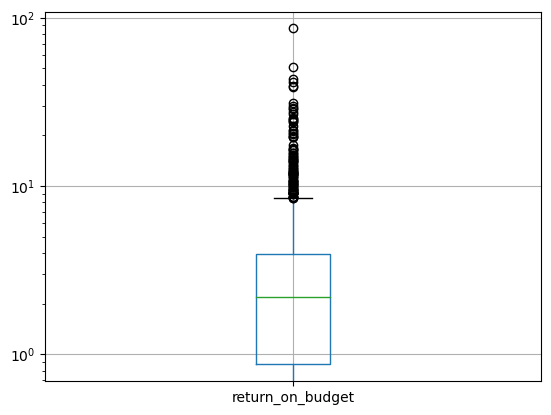

In [153]:
budget_genre[budget_genre.genre != 'horror,thriller'].boxplot('return_on_budget')
plt.yscale('log')

## Correlation Testing

<Axes: xlabel='popularity', ylabel='worldwide_gross'>

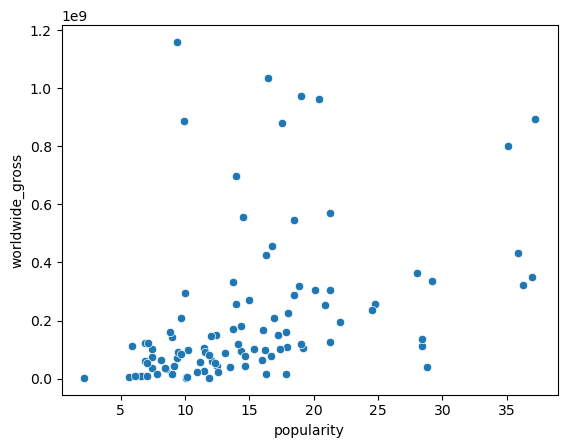

In [104]:
# assuming the budget_genre df is available
sns.scatterplot(data=budget_genre.iloc[:100], x='popularity', y='worldwide_gross')

In [120]:
budget_genre['popularity'].corr(budget_genre['worldwide_gross'])

0.63907692511969

<Axes: xlabel='vote_average', ylabel='popularity'>

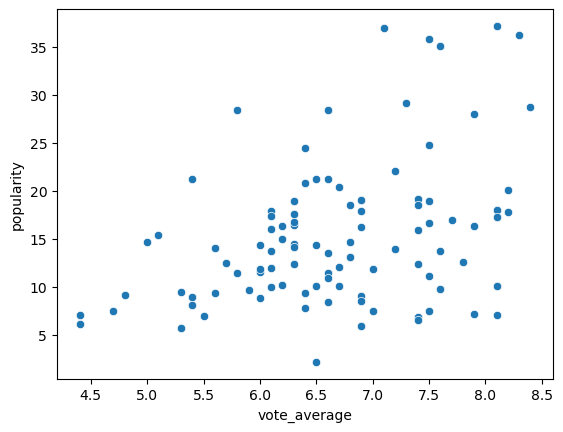

In [105]:
sns.scatterplot(data=budget_genre.iloc[:100], x='vote_average', y='popularity')

In [121]:
budget_genre['popularity'].corr(budget_genre['vote_average'])

0.356905764151298

## Popularities based on the SQL database?

In [113]:
con = sqlite3.connect('../data/im.db')

In [114]:
pd.read_sql('''
select *
from movie_basics
inner join principals
on movie_basics.movie_id = principals.movie_id
inner join persons
on principals.person_id = persons.person_id
where primary_title = 'Avatar' and category = 'director';
''', con)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,ordering,person_id,category,job,characters,person_id,primary_name,birth_year,death_year,primary_profession
0,tt1775309,Avatar,Abatâ,2011,93.0,Horror,tt1775309,5,nm3786927,director,None,None,nm3786927,Atsushi Wada,None,None,director


In [115]:
voted_movies_df = pd.read_sql('''
select *
from movie_basics
inner join movie_ratings
on movie_basics.movie_id = movie_ratings.movie_id
where numvotes > 100;
''', con)

In [116]:
voted_movies_df['augmented_score'] = voted_movies_df.averagerating * np.log10(voted_movies_df.numvotes)

In [117]:
voted_movies_df.sort_values('averagerating', ascending=False).head(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes,augmented_score
17832,tt9537008,Gini Helida Kathe,Gini Helida Kathe,2019,138.0,Drama,tt9537008,9.9,417,25.939347
24688,tt7131622,Once Upon a Time ... in Hollywood,Once Upon a Time ... in Hollywood,2019,159.0,"Comedy,Drama",tt7131622,9.7,5600,36.357424
28632,tt8718580,Eghantham,Eghantham,2018,125.0,Drama,tt8718580,9.7,639,27.213358
10771,tt6058226,Ekvtime: Man of God,Ekvtime: Man of God,2018,132.0,"Biography,Drama,History",tt6058226,9.6,2604,32.790153
25341,tt9760512,D/O Parvathamma,D/O Parvathamma,2019,NaN,Action,tt9760512,9.6,427,25.252108


In [118]:
voted_movies_df.sort_values(by=['augmented_score'], ascending=False).head(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes,augmented_score
24787,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",tt1375666,8.8,1841066,55.132610
9881,tt0816692,Interstellar,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",tt0816692,8.6,1299334,52.577999
3589,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,"Action,Thriller",tt1345836,8.4,1387769,51.595464
15032,tt1853728,Django Unchained,Django Unchained,2012,165.0,"Drama,Western",tt1853728,8.4,1211405,51.099631
23388,tt4154796,Avengers: Endgame,Avengers: Endgame,2019,181.0,"Action,Adventure,Sci-Fi",tt4154796,8.8,441135,49.672229


In [119]:
con.close()

## Proportion testing and bootstrap analysis

In [279]:
budget_df = pd.read_csv('../data/tn.movie_budgets.csv', thousands=',')

In [280]:
budget_df['production_budget'] = budget_df.production_budget.str.lstrip('$').str.replace(',', '').astype(np.int64)

In [281]:
budget_df['worldwide_gross'] = budget_df.worldwide_gross.str.lstrip('$').str.replace(',', '').astype(np.int64)

In [282]:
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 271.2+ KB


### using previous df

In [284]:
at_least_20_in_genre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 526 entries, 0 to 1419
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       526 non-null    datetime64[ns]
 1   movie              526 non-null    object        
 2   production_budget  526 non-null    int64         
 3   domestic_gross     526 non-null    object        
 4   worldwide_gross    526 non-null    int64         
 5   return_on_budget   526 non-null    float64       
 6   genre_ids          526 non-null    object        
 7   original_language  526 non-null    object        
 8   original_title     526 non-null    object        
 9   popularity         526 non-null    float64       
 10  title              526 non-null    object        
 11  vote_average       526 non-null    float64       
 12  vote_count         526 non-null    int64         
 13  genre              526 non-null    object        
dtypes: dateti

In [286]:
horror_thriller_df = at_least_20_in_genre[at_least_20_in_genre['genre'] == 'horror,thriller']

In [287]:
all_others_df = at_least_20_in_genre[at_least_20_in_genre['genre'] != 'horror,thriller']

In [370]:
def bootstrap_two_mean(small_df, large_df, column, calculated_stat, null_side_of_test='less', times=10_000):
    # null side can be less or greater
    successes = 0
    universal = pd.concat([small_df, large_df])
    small_n = len(small_df)
    universal_n = len(universal)
    for _ in range(times):
        resampled = universal.sample(n=universal_n, replace=True)
        small_df_mean = resampled.iloc[:small_n][column].mean()
        large_df_mean = resampled.iloc[small_n:][column].mean()
        if null_side_of_test == 'less' and small_df_mean - large_df_mean > calculated_stat :
            successes += 1
        elif null_side_of_test == 'greater' and small_df_mean - large_df_mean < calculated_stat:
            successes += 1
        #print(calculated_stat, small_df_mean - large_df_mean, small_df_mean - large_df_mean > calculated_stat)
    return successes / times

In [385]:
def bootstrap_two_median(small_df, large_df, column, calculated_stat, null_side_of_test='less', times=10_000):
    # null side can be less or greater
    successes = 0
    universal = pd.concat([small_df, large_df])
    small_n = len(small_df)
    universal_n = len(universal)
    for _ in range(times):
        resampled = universal.sample(n=universal_n, replace=True)
        small_df_median = resampled.iloc[:small_n][column].median()
        large_df_median = resampled.iloc[small_n:][column].median()
        if null_side_of_test == 'less' and small_df_median - large_df_median > calculated_stat:
            successes += 1
        elif null_side_of_test == 'greater' and small_df_median - large_df_median < calculated_stat:
            successes += 1
        #print(calculated_stat, small_df_median - large_df_median, small_df_median - large_df_median > calculated_stat)
    return successes / times

In [321]:
mean_difference = horror_thriller_df['return_on_budget'].mean() - all_others_df['return_on_budget'].mean()

In [388]:
bootstrap_two_mean(horror_thriller_df, all_others_df, 'return_on_budget', mean_difference)

0.0015

In [332]:
median_difference = horror_thriller_df['return_on_budget'].median() - all_others_df['return_on_budget'].median()

In [389]:
bootstrap_two_median(horror_thriller_df, all_others_df, 'return_on_budget', median_difference)

0.0

In [376]:
test_slightly_larger = np.random.normal(120, 20, 50)
test_slightly_smaller = np.random.normal(115, 20, 50)

In [377]:
a = pd.DataFrame({'r': test_slightly_larger})
b = pd.DataFrame({'r': test_slightly_smaller})

In [378]:
a.describe()

,r
count,50.000000
mean,116.943527
std,18.561794
min,77.044922
25%,107.111854
50%,117.914224
75%,127.102557
max,172.706670


In [379]:
b.describe()

,r
count,50.000000
mean,114.291894
std,18.349820
min,72.229676
25%,102.808096
50%,113.581831
75%,127.265804
max,149.700861


In [380]:
ab_mean = a['r'].mean() - b['r'].mean()
ab_median = a['r'].median() - b['r'].median()

In [387]:
bootstrap_two_median(a, b, 'r', ab_median, times=10_000)

0.1656